In [1]:
# TODO:
# put everything into one function that loads raster, resamples, and prints out a csv and df
# visualize in QGIS - are rasters correct?
# find missing tiles

In [2]:
import sys
import os
import subprocess
import datetime
import pandas as pd
import numpy as np
import pygeoprocessing
from osgeo import gdal

## Utility functions

In [23]:
def print_start_time(message=""):
    """Prints out start time of a process.
    
    Keyword arguments:
    message -- (optional) custom message indicating what process is running
    """
    print(message)
    print("Start time:", datetime.datetime.now())
    
# TODO: change input to a path 
def get_raster_resolution(raster):
    """Prints out dimensions of raster. 
    Returns pixel dimensions in tuple (pixelSizeX, pixelSizeY).
    
    Keyword arguments:
    raster -- GDAL-loaded raster to measure
    """
    # NOTE: GetGeoTransform fetches the coefficients for transforming between 
    # pixel/line (P,L) raster space, and projection coordinates (Xp,Yp) space.
    # Xp = padfTransform[0] + P*padfTransform[1] + L*padfTransform[2];
    # Yp = padfTransform[3] + P*padfTransform[4] + L*padfTransform[5];
    gt = raster.GetGeoTransform()
    print("Geotransform is", gt) 
    
    pixelSizeX = gt[1]
    pixelSizeY =-gt[5]
    pixelDims = (pixelSizeX, pixelSizeY)
    
    print("Where (pixelSizeX, pixelSizeY) is", pixelDims)
    
    return pixelDims

def resample_raster_to_resolution(raster_src_path, xres, yres, resampled_dest_path=None):
    """Uses gdalwarp to resample raster via averaging to the given resolution. 
    
    Keyword arguments:
    raster_src_path -- (dtype: string) file path to raster to resample
    xres -- (dtype: int) desired x-resolution
    yres -- (dtype: int) desired y-resolution
    """
    
    if not resampled_dest_path:
        # Get base filename without extension
        filename = os.path.basename(raster_src_path)[:-4]

        # Denote resolution of 5 arcmin to file name; alternatively, call it _resampled    
        resampled_dest_path = os.path.join(OUTPUT_DIR, filename + "_5m.tif")

    # Can specify different resampling method (-r) depending on purpose
    args = ['gdalwarp', '-tr', str(xres), str(yres), '-r', 'average', raster_src_path, resampled_dest_path]
    
    # TODO: check projection by loading in QGIS; look at resample_raster in nutrition code; mask NoData values
    
    print("Resampling raster file...start time:", datetime.datetime.now())
    
    # Call system command to run GDAL resampling
    process = subprocess.check_output(args)
    
    return resampled_dest_path
    
def convert_raster_to_xyz(raster_src_path):
    """Converts given raster to .xyz format using gdal_translate.
    
    Keyword arguments:
    raster_src_path -- (dtype: string) file path to .tif file to convert
    """
    
    # Remove 3-letter tif extension, replace with XYZ extension
    filename = os.path.basename(raster_src_path)[:-4]
    xyz_filename = ('{}.xyz').format(filename)
    
    xyz_dest_path = os.path.join(OUTPUT_DIR, xyz_filename)
    
    # Arguments for GDAL translation
    args = ["gdal_translate", raster_src_path, xyz_dest_path, "-co", "ADD_HEADER_LINE=YES"]
    
    print("Now converting raster into XYZ format...start time:", datetime.datetime.now())
    
    # Call system command to run GDAL translation
    process = subprocess.check_output(args)
    
    print("Saved new XYZ file to", xyz_dest_path)
    return xyz_dest_path

def convert_xyz_to_df(xyz_src_path, value_col_name):
    """Reads XYZ file into a dataframe with columns {"pixel_id", "lat", "long", "value"}.
    Returns this dataframe. 
    
    Keyword arguments:
    xyz_src_path -- (dtype: string) file path to .xyz file to read in
    """
    
    print("Now reading file into dataframe...start time:", datetime.datetime.now())
    df = pd.read_csv(xyz_src_path, delimiter=' ')
    df.index.name = 'pixel_id'
    df.rename(columns={'X': 'lat', 'Y': 'long', 'Z': value_col_name}, inplace=True)
    print(df.head)
    return df

def convert_raster_to_df(tif_src_path, value_col_name="value"):
    """Reads a raster file into a dataframe with columns {"pixel_id", "lat", "long", "value"}
    Returns this dataframe. 
    
    Keyword arguments:
    xyz_src_path -- (dtype: string) file path to raster file to read in
    """
    dest_path = convert_raster_to_xyz(tif_src_path)
    new_df = convert_xyz_to_df(dest_path, value_col_name)
    return new_df

## TODO: write wrapper function
## def resample_and_convert_to_csv():
    """Wrapper function to take in a raster file, resample it to the desired resolution, 
    read it into a dataframe, and save it to a csv file.
    """
    
# TODO: This still doesn't really work without pulling up the terminal. Why?? 
def merge_rasters(dir_of_rasters):
    """Merges list of rasters into one raster.
    
    Keyword arguments:
    dir_of_rasters -- (dtype: string) file path to directory containing all rasters to be merged
    """
    
    # gdalbuildvrt mosaic.vrt c:\data\....\*.tif
    # gdal_translate -of GTiff -co "COMPRESS=JPEG" -co "PHOTOMETRIC=YCBCR" -co "TILED=YES" mosaic.vrt mosaic.tif

    raster_list = os.listdir(dir_of_rasters)
    num_files = len(raster_list)
    
    vrt_name = os.path.basename(dir_of_rasters)+'.vrt'
    file_space = os.path.join(dir_of_rasters, '*.tif')
    builtvrt_args = ['gdalbuildvrt', vrt_name, file_space]
    print(builtvrt_args)
    print("Merging "+str(num_files)+" files into virtual raster...", datetime.datetime.now())
    
    buildvrt_process = subprocess.check_output(builtvrt_args)
    
    tif_name =  dir_of_rasters+'.tif'
    translate_args = ['gdal_translate', '-of', 'GTiff', '-co', '"COMPRESS=JPEG"', 
                     '-co', '"PHOTOMETRIC=YCBCR"', '-co', '"TILED=YES"', vrt_name,  
                     tif_name]
    print(translate_args)
    print("Merging virtual raster into true raster...", datetime.datetime.now())

    translate_process = subprocess.check_output(translate_args)


## Main 

In [3]:
# Define working directories
NAT_CAP_DIR = '/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project'
CARBON_DIR = os.path.join(NAT_CAP_DIR, 'Carbon')
CARBON_DATA_DIR = os.path.join(CARBON_DIR, 'Data')
OUTPUT_DIR = os.path.join(CARBON_DIR, 'Outputs')
PEOPLE_DIR = os.path.join(NAT_CAP_DIR, 'People')

# To access biomass data
carbon_biomass_folder = 'GFW_ALWBD_2000'
BIOMASS_DIR = os.path.join(CARBON_DATA_DIR, carbon_biomass_folder)

# test_foldername = 'test_NE1_50M_SR'
# test_filename = 'NE1_50M_SR.tif'
# path_to_test_raster = os.path.join(CARBON_DIR, test_foldername, test_filename)

# To access biomass data
market_dist_foldername = 'Distance_to_market'
market_dist_filename = 'minutes_to_market_5m.tif'
path_to_market_dist_raster = os.path.join(PEOPLE_DIR, market_dist_foldername, market_dist_filename)

In [ ]:
# Find desired resolution for 5 arcmins
mins_to_market_raster = gdal.Open(path_to_market_dist_raster)
(Xres, Yres) = get_raster_resolution(mins_to_market_raster)

# Resample the larger raster down to 5arcmin
path_to_test_raster_resampled = resample_raster_to_resolution(path_to_test_raster, Xres, Yres)

In [ ]:
# Load new resampled raster
test_raster = gdal.Open(path_to_test_raster_resampled)
get_raster_resolution(test_raster)

In [ ]:
# Read rasters into dataframes. This takes several minutes - be patient and only re-run when necessary.
test_df = convert_raster_to_df(path_to_test_raster_resampled)
# market_dist_df = convert_raster_to_df(path_to_market_dist_raster)                           

In [ ]:
print(test_df)
print(test_df.shape)
print(market_dist_df)      
print(market_dist_df.shape)

In [ ]:
merged_df = test_df.merge(market_dist_df, on=['pixel_id', 'lat', 'long'], suffixes=('_color', '_mins'))

In [ ]:
merged_df1 = test_df.merge(market_dist_df, on=['pixel_id'], suffixes=('_color', '_mins'))

In [ ]:
merged_df1

In [4]:
abg_biomass_files = os.listdir(BIOMASS_DIR)
desired_resolution = (0.083333333333333, 0.083333333333333)
resolution_tag = "_5m"

count = 0
print_start_time("Resampling carbon rasters...")
for filename in abg_biomass_files:
    raster_name = filename[:-4]
    extension = filename[-4:]
    if extension == '.tif':
    # TODO: add check that resampled raster doesn't already exist
        src_path = os.path.join(BIOMASS_DIR, filename)
        dest_path = os.path.join(OUTPUT_DIR, 
                                 carbon_biomass_folder+resolution_tag, 
                                 raster_name+resolution_tag+extension)
        
        try:
            resample_raster_to_resolution(src_path, 
                                      desired_resolution[0], 
                                      desired_resolution[1], 
                                      resampled_dest_path=dest_path)
            print("Successfully resampled raster:", raster_name)
            get_raster_resolution(dest_path)
            count += 1
        except:
            print("Resampled raster:", raster_name+resolution_tag, "already exists. Trying next one...")
        
    if count > 2:
        break

Resampling carbon rasters...
Start time: 2019-05-20 13:07:15.690789
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_070W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:07:15.691643
Resampled raster: 70N_070W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/40N_020W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:07:15.753322
Resampled raster: 40N_020W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/50N_130E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:07:15.790279
Resampled raster: 50N_130E_t_aboveground_biomass_ha_

Successfully resampled raster: 40N_020E_t_aboveground_biomass_ha_2000
Resampled raster: 40N_020E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/50S_060W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:09:52.357272
Successfully resampled raster: 50S_060W_t_aboveground_biomass_ha_2000
Resampled raster: 50S_060W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/80N_010E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:10:04.192349
Successfully resampled raster: 80N_010E_t_aboveground_biomass_ha_2000
Resampled raster: 80N_010E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 10N_100W_t_aboveground_biomass_ha_2000
Resampled raster: 10N_100W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_170W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:13:01.357992
Successfully resampled raster: 70N_170W_t_aboveground_biomass_ha_2000
Resampled raster: 70N_170W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/60N_060E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:13:14.135240
Successfully resampled raster: 60N_060E_t_aboveground_biomass_ha_2000
Resampled raster: 60N_060E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 40N_120E_t_aboveground_biomass_ha_2000
Resampled raster: 40N_120E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/10N_100E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:18:18.469194
Successfully resampled raster: 10N_100E_t_aboveground_biomass_ha_2000
Resampled raster: 10N_100E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_170E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:18:33.746958
Successfully resampled raster: 70N_170E_t_aboveground_biomass_ha_2000
Resampled raster: 70N_170E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 70N_120W_t_aboveground_biomass_ha_2000
Resampled raster: 70N_120W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/20N_100W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:25:13.931768
Successfully resampled raster: 20N_100W_t_aboveground_biomass_ha_2000
Resampled raster: 20N_100W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/10N_090E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:27:37.257757
Successfully resampled raster: 10N_090E_t_aboveground_biomass_ha_2000
Resampled raster: 10N_090E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 10N_090W_t_aboveground_biomass_ha_2000
Resampled raster: 10N_090W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/20N_100E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:47:15.214435
Successfully resampled raster: 20N_100E_t_aboveground_biomass_ha_2000
Resampled raster: 20N_100E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/00N_140E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:47:38.023748
Successfully resampled raster: 00N_140E_t_aboveground_biomass_ha_2000
Resampled raster: 00N_140E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 20N_000E_t_aboveground_biomass_ha_2000
Resampled raster: 20N_000E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/40N_070E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:53:16.069846
Successfully resampled raster: 40N_070E_t_aboveground_biomass_ha_2000
Resampled raster: 40N_070E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_020E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 13:53:33.674414
Successfully resampled raster: 70N_020E_t_aboveground_biomass_ha_2000
Resampled raster: 70N_020E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 10S_070W_t_aboveground_biomass_ha_2000
Resampled raster: 10S_070W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_150W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:02:18.605177
Successfully resampled raster: 70N_150W_t_aboveground_biomass_ha_2000
Resampled raster: 70N_150W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/30N_090W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:02:40.419755
Successfully resampled raster: 30N_090W_t_aboveground_biomass_ha_2000
Resampled raster: 30N_090W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 10S_080W_t_aboveground_biomass_ha_2000
Resampled raster: 10S_080W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/40N_030E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:08:06.704249
Successfully resampled raster: 40N_030E_t_aboveground_biomass_ha_2000
Resampled raster: 40N_030E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/20N_040E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:08:18.700981
Successfully resampled raster: 20N_040E_t_aboveground_biomass_ha_2000
Resampled raster: 20N_040E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 20N_070W_t_aboveground_biomass_ha_2000
Resampled raster: 20N_070W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/80N_100E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:13:40.579750
Successfully resampled raster: 80N_100E_t_aboveground_biomass_ha_2000
Resampled raster: 80N_100E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/60N_070W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:13:57.038555
Successfully resampled raster: 60N_070W_t_aboveground_biomass_ha_2000
Resampled raster: 60N_070W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 20N_110W_t_aboveground_biomass_ha_2000
Resampled raster: 20N_110W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/10N_080E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:19:10.074490
Successfully resampled raster: 10N_080E_t_aboveground_biomass_ha_2000
Resampled raster: 10N_080E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/70N_130W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:19:20.857364
Successfully resampled raster: 70N_130W_t_aboveground_biomass_ha_2000
Resampled raster: 70N_130W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 60N_020W_t_aboveground_biomass_ha_2000
Resampled raster: 60N_020W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/80N_090W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:25:20.970331
Successfully resampled raster: 80N_090W_t_aboveground_biomass_ha_2000
Resampled raster: 80N_090W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/50N_070W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:25:31.145577
Successfully resampled raster: 50N_070W_t_aboveground_biomass_ha_2000
Resampled raster: 50N_070W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 70N_030W_t_aboveground_biomass_ha_2000
Resampled raster: 70N_030W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/20N_010W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:43:40.856296
Successfully resampled raster: 20N_010W_t_aboveground_biomass_ha_2000
Resampled raster: 20N_010W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/30N_100E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:43:57.723242
Successfully resampled raster: 30N_100E_t_aboveground_biomass_ha_2000
Resampled raster: 30N_100E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Activ

Successfully resampled raster: 30N_100W_t_aboveground_biomass_ha_2000
Resampled raster: 30N_100W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/80N_050E_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:50:00.974068
Successfully resampled raster: 80N_050E_t_aboveground_biomass_ha_2000
Resampled raster: 80N_050E_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...
/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Data/GFW_ALWBD_2000_5m/60N_120W_t_aboveground_biomass_ha_2000_5m.tif
Resampling raster file...start time: 2019-05-20 14:50:11.746974
Successfully resampled raster: 60N_120W_t_aboveground_biomass_ha_2000
Resampled raster: 60N_120W_t_aboveground_biomass_ha_2000_5m already exists. Trying next one...


In [21]:
raster_path = os.path.join(OUTPUT_DIR, "GFW_ALWBD_2000_5m.tif")
raster = gdal.Open(raster_path)
get_raster_resolution(raster)

Geotransform is (-180.0, 0.08333333333333245, 0.0, 80.0, 0.0, -0.08333333333333245)
Where (pixelSizeX, pixelSizeY) is (0.08333333333333245, 0.08333333333333245)


(0.08333333333333245, 0.08333333333333245)

In [20]:
carbon_raster_dir = os.path.join(OUTPUT_DIR, "GFW_ALWBD_2000_5m")
merge_rasters(carbon_raster_dir)

['gdalbuildvrt', 'GFW_ALWBD_2000_5m.vrt', '/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Outputs/GFW_ALWBD_2000_5m/*.tif']
Merging 281 files into virtual raster... 2019-05-20 17:25:08.949432
['gdal_translate', '-of', 'GTiff', '-co', '"COMPRESS=JPEG"', '-co', '"PHOTOMETRIC=YCBCR"', '-co', '"TILED=YES"', 'GFW_ALWBD_2000_5m.vrt', '/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Outputs/GFW_ALWBD_2000_5m.tif']
Merging virtual raster into true raster... 2019-05-20 17:25:08.949567


CalledProcessError: Command '['gdal_translate', '-of', 'GTiff', '-co', '"COMPRESS=JPEG"', '-co', '"PHOTOMETRIC=YCBCR"', '-co', '"TILED=YES"', 'GFW_ALWBD_2000_5m.vrt', '/Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Outputs/GFW_ALWBD_2000_5m.tif']' returned non-zero exit status 1.

In [25]:
carbon_df = convert_raster_to_df(raster_path, value_col_name="carbon")

Now converting raster into XYZ format...start time: 2019-05-20 17:39:28.301043
Saved new XYZ file to /Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Outputs/GFW_ALWBD_2000_5m.xyz
Now reading file into dataframe...start time: 2019-05-20 17:39:52.114347
<bound method NDFrame.head of                  lat       long  carbon
pixel_id                               
0        -179.958333  79.958333       0
1        -179.875000  79.958333       0
2        -179.791667  79.958333       0
3        -179.708333  79.958333       0
4        -179.625000  79.958333       0
5        -179.541667  79.958333       0
6        -179.458333  79.958333       0
7        -179.375000  79.958333       0
8        -179.291667  79.958333       0
9        -179.208333  79.958333       0
10       -179.125000  79.958333       0
11       -179.041667  79.958333       0
12       -178.958333  79.958333       0
13       -178.875000  79.958333       0
14       -178.791667  79.9583

In [26]:
carbon_df.loc[carbon_df["carbon"] > 0]

,lat,long,carbon
pixel_id,,,
120046,103.875000,77.708333,3
120047,103.958333,77.708333,2
120048,104.041667,77.708333,2
120049,104.125000,77.708333,2
120050,104.208333,77.708333,2
120051,104.291667,77.708333,2
120052,104.375000,77.708333,3
120053,104.458333,77.708333,3
120054,104.541667,77.708333,7


In [27]:
market_df = convert_raster_to_df(path_to_market_dist_raster)

Now converting raster into XYZ format...start time: 2019-05-20 23:51:49.377435
Saved new XYZ file to /Users/jackieennis/Google Drive/Classes/Active Classes/Impact Lab/Carbon Students Project/Carbon/Outputs/minutes_to_market_5m.xyz
Now reading file into dataframe...start time: 2019-05-20 23:52:39.751669
<bound method NDFrame.head of                  lat       long       value
pixel_id                                   
0        -179.958333  89.958333 -2147483647
1        -179.875000  89.958333 -2147483647
2        -179.791667  89.958333 -2147483647
3        -179.708333  89.958333 -2147483647
4        -179.625000  89.958333 -2147483647
5        -179.541667  89.958333 -2147483647
6        -179.458333  89.958333 -2147483647
7        -179.375000  89.958333 -2147483647
8        -179.291667  89.958333 -2147483647
9        -179.208333  89.958333 -2147483647
10       -179.125000  89.958333 -2147483647
11       -179.041667  89.958333 -2147483647
12       -178.958333  89.958333 -2147483647
13    

In [41]:
merged_df1 = carbon_df.merge(market_df, on=['pixel_id'], suffixes=('_color', '_mins'))

In [42]:
merged_df1

,lat_color,long_color,carbon,lat_mins,long_mins,value
pixel_id,,,,,,
0,-179.958333,79.958333,0,-179.958333,89.958333,-2147483647
1,-179.875000,79.958333,0,-179.875000,89.958333,-2147483647
2,-179.791667,79.958333,0,-179.791667,89.958333,-2147483647
3,-179.708333,79.958333,0,-179.708333,89.958333,-2147483647
4,-179.625000,79.958333,0,-179.625000,89.958333,-2147483647
5,-179.541667,79.958333,0,-179.541667,89.958333,-2147483647
6,-179.458333,79.958333,0,-179.458333,89.958333,-2147483647
7,-179.375000,79.958333,0,-179.375000,89.958333,-2147483647
8,-179.291667,79.958333,0,-179.291667,89.958333,-2147483647


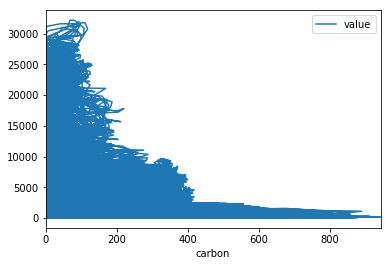

In [43]:
merged_df1.loc[merged_df1['value'] < 0] = 0
merged_df1.plot(x='carbon', y='value')

In [47]:
merged_df1['carbon'].corr(merged_df1['value'])

0.12783552841670884

In [49]:
# TODO: is correlation better than random? 
# Correlation matrix